## Example: Fitting a linear background

Suppose we have an experiment where some physical process generates a peak signal of a certain height at a certain scale (energy, frequency, wavelength). As all experiments, the signal is affected by a background noise. Let us assume we can measure this background noise on a separate data acquisition where we do not expect any signal. 

`GOAL: Find a model for the background and use it to extract the pure signal from the experimental setup.`

### Generate synthetic experiment

We use the support material for the course. Let us load the code: `supplemental_material/synth_dataset.py`

In [1]:
import sys
sys.path.append('../../../supplemental_material')

import numpy as np
import matplotlib.pyplot as plt
import synth_dataset as sd


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Let us produce the synthetic experiment data take 1

In [2]:
# array of x values
x = np.linspace(0,1,100)
# produce a single gaussian peak signal
signal = sd.random_peaks(x,peaks_range=[1,2],c = 0.05, ph_min = 0.1, ph_max = 0.5, edge_tol=0.2,method=2)
# produce a linear background 
background = sd.linear_bg(len(x))
# add random noise to generate the raw signal
raw = sd.add_noise(snr=20, signal = signal + background)

We look at the data

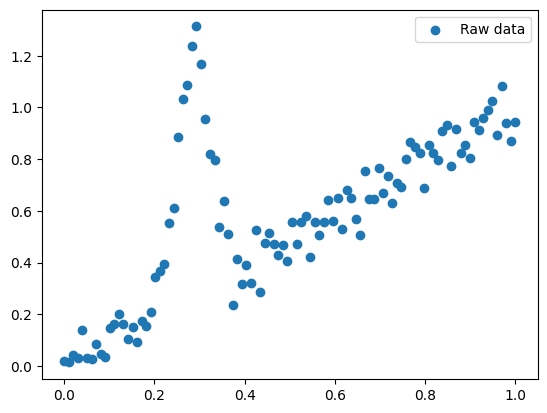

In [3]:
# plot the data
plt.scatter(x,raw,label='Raw data')
plt.legend()
plt.show()

Now suppose we take again the measurement without any material, or object of interest, so that we can measure the background.

To do this, we take the same background as in the data take 1, and add again some random noise on top of it. This random noise represents the many uncertainties in the instrument itself, the environment, or anything else that cannot be assumed or modeled to have a specific behaviour (differently than the background)

In [4]:
background2 = sd.add_noise(snr=20, signal = background)

We plot it:

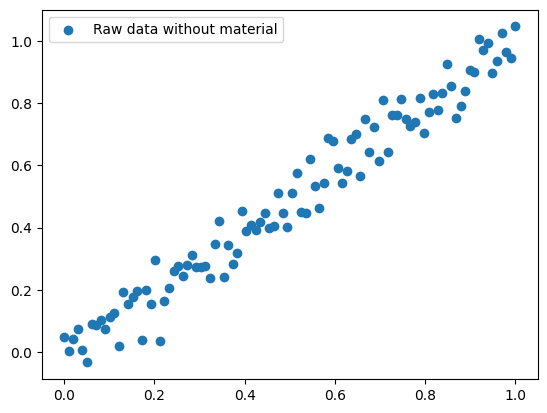

In [5]:
plt.scatter(x,background2,label='Raw data without material')
plt.legend()
plt.show()

### Modelling the background

Despite the noise, the behaviour of the background seems quite clearly linear. We can thus assume a background of the type:

$\hat b_i = \hat\alpha\, x_i + \hat\beta$.

To test our assumption, we are interested in minimizing the residual $e_i = b_i - \hat b_i$, which is the difference between the ith observed background value and the ith predicted value
by our linear model, given a $x_i$.

We therefore define the *residual sum of squares*

$S = e_1^2 + ... + e_n^2$,

which we would like to minimize varying $\hat \alpha$ and $\hat \beta$ to find the linear model that most closely resembles the measurements.

With some algebra, we easily find that the minimization wrt $\alpha$ and $\beta$ gives:

$ \hat \alpha = \bar b - \hat \beta \bar x$

$ \hat \beta = \frac{\sum_{i=1}^{n} (x_i - \bar x)(b_i - \bar b)}{\sum_{i=1}^n (x_i - \bar x)^2}$

where the bar represents the sample mean $\bar A = \frac{1}{n}\, \sum_{i=1}^n A_i$.

Let us now implement this finding to our example

In [6]:
beta = np.sum((x-np.mean(x))*(background2 - np.mean(background2)))/np.sum((x-np.mean(x))**2)

alpha = np.mean(background2) - np.mean(x)*beta

Let us see if it works:

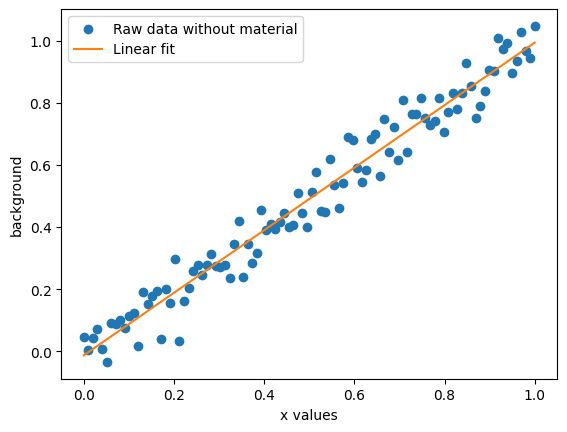

In [7]:
plt.scatter(x,background2,label='Raw data without material', c='C0')
plt.plot(x,alpha + beta*x,label='Linear fit', c='C1')
plt.xlabel('x values')
plt.ylabel('background')
plt.legend()
plt.show()

Now we can use this model to subtract the background:

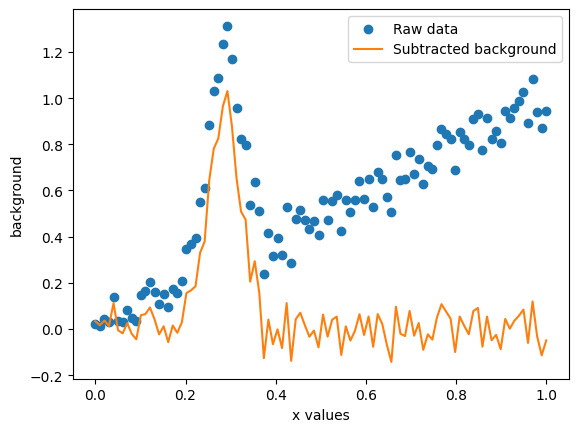

In [8]:
plt.scatter(x,raw,label='Raw data', c='C0')
plt.plot(x,raw - (alpha + beta*x),label='Subtracted background', c='C1')
plt.xlabel('x values')
plt.ylabel('background')
plt.legend()
plt.show()

Extra: we can try to further clean the signal by taking the same experiment multiple times, so that the Gaussian noise averages out.

In order to keep the same signal as before, we just artificially add noise to the same signal, assuming it is very stable in time.

In [44]:
takes = 10
# add random noise 
background_many_takes = [sd.add_noise(snr=20, signal = background) for i in range(takes)]

Now we can calculate alpha and beta for each take separately and then combine them together to get an estimate of their error based on the standard deviation of the 20 takes

In [45]:
beta_many_takes = [np.sum((x-np.mean(x))*(background_many_takes[i] - np.mean(background_many_takes[i])))/np.sum((x-np.mean(x))**2) for i in range(takes)]

alpha_many_takes = [np.mean(background_many_takes[i]) - np.mean(x)*beta_many_takes[i] for i in range(takes)]

model_many_takes = [alpha_many_takes[i] + beta_many_takes[i]*x for i in range(takes)]

In [46]:
model_mean = np.mean(model_many_takes, axis=0)
model_std = np.std(model_many_takes, axis=0,ddof=1)

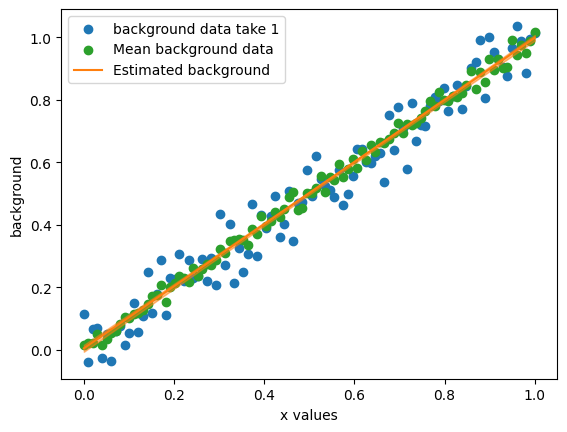

In [49]:
plt.scatter(x,background_many_takes[0],label='background data take 1', c='C0')
plt.scatter(x,np.mean(background_many_takes,axis=0),label='Mean background data', c='C2')
plt.plot(x,model_mean,label='Estimated background', c='C1')
plt.fill_between(x, model_mean + model_std, model_mean - model_std, color='C1', alpha=0.5)
plt.xlabel('x values')
plt.ylabel('background')
plt.legend()
plt.show()